In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled)


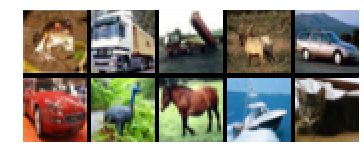

In [3]:
### Importing and preparing data ###

from fuel.datasets.cifar10 import CIFAR10
from fuel.transformers import ScaleAndShift, Cast#, Flatten, Mapping
from fuel.streams import DataStream
from fuel.schemes import SequentialScheme, ShuffledScheme

from common.plotting import plot_mat

features = CIFAR10(("train",), subset=slice(None,40000)).data_sources[0]
targets = CIFAR10(("train",), subset=slice(None,40000)).data_sources[1]

#print features[0].shape
plot_mat(array(features[0:10]))
#print targets[0].shape

CIFAR10.default_transformers = (
    (ScaleAndShift, [2.0 / 255.0, -1], {'which_sources': 'features'}),
    (Cast, [np.float32], {'which_sources': 'features'}))
    # (Flatten, [], {'which_sources': 'features'}),
    #(Mapping, [lambda batch: (b.T for b in batch)], {}) )

cifar_train = CIFAR10(("train",), subset=slice(None,40000))

cifar_train_stream = DataStream.default_stream(
    cifar_train,
    iteration_scheme=ShuffledScheme(cifar_train.num_examples, 200))
                                               
cifar_validation = CIFAR10(("train",), subset=slice(40000, None))

cifar_validation_stream = DataStream.default_stream(
    cifar_validation, iteration_scheme=SequentialScheme(cifar_validation.num_examples, 250))
cifar_test = CIFAR10(("test",))
cifar_test_stream = DataStream.default_stream(
    cifar_test, iteration_scheme=SequentialScheme(cifar_test.num_examples, 250))

In [4]:
import theano
import theano.tensor as T
import lasagne
import time
import sys
from six.moves import cPickle

/home/i248066/.local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [5]:
### Neural network architecture

def build_net(input_var=None):

    network = lasagne.layers.InputLayer(shape=(None, 3, 32, 32),
                                        input_var=input_var)
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=128, filter_size=(5, 5), pad=1,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))

    network = lasagne.layers.Conv2DLayer(
            network, num_filters=256, filter_size=(5, 5), pad=1,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())

    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    #network = lasagne.layers.PadLayer(network, 1)

    network = lasagne.layers.Conv2DLayer(
            network, num_filters=512, filter_size=(3, 3), pad=1,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    
    network = lasagne.layers.Conv2DLayer(
            network, num_filters=1024, filter_size=(2, 2),
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
    
    network = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(network, p=.5),
            num_units=10,
            nonlinearity=lasagne.nonlinearities.softmax)
    
    return network

In [6]:
def weight_decay(loss_function, pred, target, factor=0.01, deterministic=False):
    loss = loss_function(pred, target)
    if not deterministic:
        reg = lasagne.regularization.l2(pred)
        return loss + factor * reg
    else:
        return loss

In [7]:
### Theano functions creation ###
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')

net = build_net(input_var)

pred = lasagne.layers.get_output(net)
#loss = lasagne.objectives.categorical_crossentropy(pred, target_var).mean()
loss = weight_decay(lasagne.objectives.categorical_crossentropy, pred, target_var, factor=0.1).mean()

params = lasagne.layers.get_all_params(net, trainable=True)

# gradient update scheme and hyperparameters, pretty self-explanationary
updates = lasagne.updates.nesterov_momentum(loss, params, learning_rate=0.01, momentum=0.9)

# remember to disable dropout on testing (with deterministic=True) :)
test_prediction = lasagne.layers.get_output(net, deterministic=True)

test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, target_var).mean()

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)

train_fn = theano.function([input_var, target_var], loss, updates=updates)

val_fn = theano.function([input_var, target_var], [test_loss, test_acc])

/home/i248066/.local/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [6]:
### Network training ###

num_epochs=3
patience = 1.5
best_error = inf
epoch = 0
start_time = time.time()
while epoch < num_epochs:
    epoch += 1
    train_error = nbatches = 0
    for X,Y in cifar_train_stream.get_epoch_iterator(): 
        train_error += train_fn(X, Y.ravel())
        nbatches += 1
    train_error /= nbatches
    
    # After an epoch compute validation error
    validation_error = validation_accuracy = nbatches = 0
    for X,Y in cifar_validation_stream.get_epoch_iterator():
        err, acc = val_fn(X, Y.ravel())
        validation_error += err
        validation_accuracy += acc
        nbatches += 1
    validation_error /= nbatches  
    validation_accuracy /= nbatches 
         
    if validation_error < best_error:
        num_epochs = np.maximum(num_epochs, epoch * patience+1)
        best_error = validation_error
        #best_params = deepcopy(net.parameters)

        
    print("{}/{} ({:.1f}s) train_error: {:.6f} validation_error: {:.6f} validation_accuracy: {:.2f} %".format(
            epoch, num_epochs, time.time() - start_time, 
            train_error , validation_error, validation_accuracy * 100))
    sys.stdout.flush()

1/3.0 (29.3s) train_error: 4.203004 validation_error: 2.049740 validation_accuracy: 47.77 %
2/4.0 (58.9s) train_error: 4.135970 validation_error: 2.004929 validation_accuracy: 54.78 %
3/5.5 (89.7s) train_error: 4.105847 validation_error: 1.964034 validation_accuracy: 60.62 %
4/7.0 (120.1s) train_error: 4.083251 validation_error: 1.933742 validation_accuracy: 63.51 %
5/8.5 (150.6s) train_error: 4.066516 validation_error: 1.930875 validation_accuracy: 66.25 %
6/10.0 (181.0s) train_error: 4.053376 validation_error: 1.904670 validation_accuracy: 66.97 %
7/11.5 (211.4s) train_error: 4.042086 validation_error: 1.888212 validation_accuracy: 68.94 %
8/13.0 (241.7s) train_error: 4.032001 validation_error: 1.868867 validation_accuracy: 70.45 %
9/14.5 (271.9s) train_error: 4.022885 validation_error: 1.862604 validation_accuracy: 72.46 %
10/14.5 (302.1s) train_error: 4.014588 validation_error: 1.864651 validation_accuracy: 72.98 %
11/17.5 (332.3s) train_error: 4.008537 validation_error: 1.854982 v

/home/i248066/.local/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [8]:
def compute_accuracy(val_fn, stream):
    error = accuracy = nbatches = 0
    for X,Y in stream.get_epoch_iterator():
        err, acc = val_fn(X, Y.ravel())
        error += err
        accuracy += acc
        nbatches += 1

    print("Test set results:")
    print("loss:\t\t{:.6f} ".format(error/nbatches))
    print("accuracy:\t{:.2f} %".format(accuracy/nbatches * 100))

In [ ]:
#saving the data
params = lasagne.layers.get_all_param_values(net)

f = open('params.bin', 'wb')
cPickle.dump(params, f, protocol=cPickle.HIGHEST_PROTOCOL)
f.close()

In [9]:
#loading data
f = open('params.bin', 'rb')
params_loaded = cPickle.load(f)
f.close()

lasagne.layers.set_all_param_values(net, params_loaded)
compute_accuracy(val_fn, cifar_test_stream)

Test set results:
loss:		1.806378 
accuracy:	80.03 %


In [29]:
#saving the results
f = open('results', 'w')

for X,Y in cifar_test_stream.get_epoch_iterator():
    preds = lasagne.layers.get_output(net, X).eval()
    for p, y in zip(preds, Y.ravel()):
        f.write("{} {}\n".format(argmax(p), y))
        
f.close()